In [1]:
from plotnine import *
import pandas as pd
import numpy as np

In [19]:
# time = "2024-03-29_04:53"
time = "2024-03-29_07:23"
time = "2024-03-31_15:54"
time = "2024-03-31_16:37"
time = "2024-03-31_17:12"
time = "2024-04-01_15:42"
time = "2024-04-01_17:06"
time = "2024-04-01_18:11"
time = "2024-04-16_16:47"
time = "2024-04-18_19:23"
time = "2024-04-18_20:30"
time = "2024-04-19_01:29"
time = "2024-04-19_09:39"
time = "2024-05-19_16:34"
time = "2024-05-19_16:58"
time = "2024-05-19_17:38"
time = "2024-05-19_18:55"
time = "2024-05-20_04:15"
time = "2024-05-20_10:30"
time = "2024-05-29_13:27"
time = "2024-06-10_12:52" # EUR_USD_M15
time = "2024-06-10_19:47" # GBP_USD_M15
time = "2024-06-10_22:59" # USD_JPY_M15
time = "2024-06-11_04:01" # USD_CHF_M15
time = "2024-06-11_04:14" # USD_CAD_M15
time = "2024-06-11_11:42" # AUD_USD_M15
time = "2024-06-11_23:43" # AUD_JPY_M15
time = "2024-06-11_23:48" # AUD_CAD_M15


time = "2024-06-12_08:44" # EUR_JPY_M15
time = "2024-06-12_08:48" # GBP_CHF_M15
#time = "2024-06-12_08:52" # GBP_JPY_M15

df = pd.read_csv(f"/projects/genomic-ml/da2343/ml_project_2/unsupervised/kmeans/results/{time}_results.csv")

# df['test_cumsum_annualized_return'] = df['test_cumsum_annualized_return'] * -1
# remove where dist_measure is 2
# remove where future_candles is 5
# remove where n_clusters is 150 or 200
# remove where log_return_threshold is greater than 0.01
# remove where calmar_ratio_threshold is not 2

# df = df[df["dist_measure"] != 2]
# df = df[df["window"] < 5]
# df = df[df["random_state"] == 42]
# df = df[df["test_size"] == 2880]
# df = df[df["algorithm"] == "kmeans"]
# df = df[(df["test_negative_sharpe_ratio"] >= 1) | (df["test_sharpe_ratio"] >= 1)]
df = df[(df["test_negative_sharpe_ratio"] >= 0.15) | (df["test_sharpe_ratio"] >= 0.15)]

# df = df[(df["algorithm"] == 'gaussian_mixture')]
# df = df[(df["max_k_labels"] == 1)]
# df = df[(df["random_state"] == 200)]

df

,window,train_sum_annualized_return,train_sum_actual_return,train_n_trades,test_sum_annualized_return,test_sum_actual_return,test_n_trades,train_cumsum_annualized_return,train_cumsum_actual_return,train_sharpe_ratio,test_cumsum_annualized_return,test_cumsum_actual_return,test_sharpe_ratio,test_negative_sharpe_ratio,max_k_labels,n_clusters,algorithm,train_size,test_size,random_state
3557,0,1.99,199,310,-0.36,-36,126,1.99,199,3.507968,-0.36,-36,-0.222325,0.162560,5,70,kmeans,3840,960,1
3558,1,1.61,161,333,-0.15,-15,79,3.60,360,3.507968,-0.51,-51,-0.222325,0.162560,5,70,kmeans,3840,960,1
3559,2,1.41,141,278,0.11,11,53,5.01,501,3.507968,-0.40,-40,-0.222325,0.162560,5,70,kmeans,3840,960,1
3560,3,1.33,133,302,-0.44,-44,88,6.34,634,3.507968,-0.84,-84,-0.222325,0.162560,5,70,kmeans,3840,960,1
3561,4,1.69,169,324,0.07,7,103,8.03,803,3.507968,-0.77,-77,-0.222325,0.162560,5,70,kmeans,3840,960,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491054,120,1.58,158,328,0.07,7,63,188.25,18825,3.518835,-7.78,-778,-0.212510,0.156231,5,70,kmeans,3840,960,12
491055,121,2.22,222,342,-0.11,-11,75,190.47,19047,3.518835,-7.89,-789,-0.212510,0.156231,5,70,kmeans,3840,960,12
491056,122,1.39,139,322,0.01,1,91,191.86,19186,3.518835,-7.88,-788,-0.212510,0.156231,5,70,kmeans,3840,960,12
491057,123,1.71,171,384,0.36,36,65,193.57,19357,3.518835,-7.52,-752,-0.212510,0.156231,5,70,kmeans,3840,960,12


/projects/genomic-ml/da2343/cs685/lib/python3.9/site-packages/plotnine/facets/facet.py:446: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


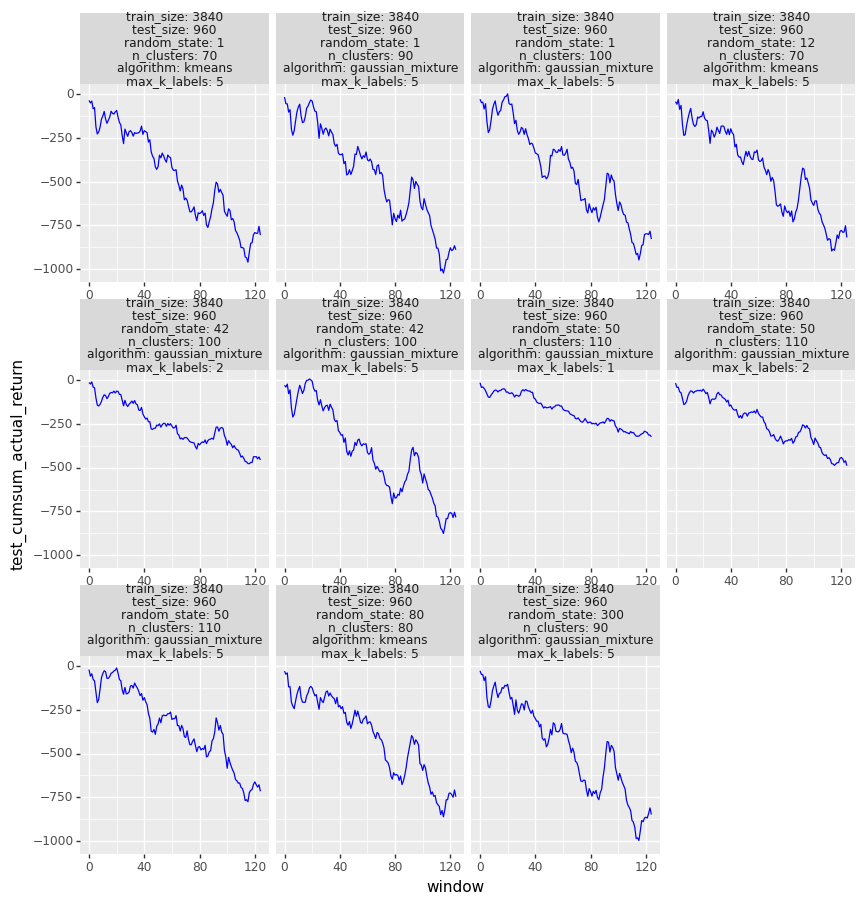

In [20]:
p = ggplot(df)
# p = p + geom_line(aes(x="window", y="train_cumsum_annualized_return"), color="red")
p = p + geom_line(aes(x="window", y="test_cumsum_actual_return"), color="blue")
# p = p + geom_line(aes(x="window", y="val_avg_calmar_ratio"), color="red")
# p = p + facet_wrap("~train_size + random_state", scales="free_x", labeller="label_both")
p = p + facet_wrap("~train_size + test_size + random_state + n_clusters + algorithm + max_k_labels", scales="free_x", labeller="label_both")
# p = p + theme(figure_size=(35, 35))
p = p + theme(figure_size=(10, 10))
print(p)

In [ ]:

time = "2024-03-14_19:00"
df = pd.read_csv(f"/projects/genomic-ml/da2343/ml_project_2/kmeans/results/{time}_results.csv")

p = ggplot(df)
p = p + geom_line(aes(x="window", y="test_cumsum_annualized_return"), color="blue")
# p = p + geom_line(aes(x="window", y="val_cumsum_annualized_return"), color="red")
p = p + facet_wrap("~train_size + test_size + random_state", scales="free_x", labeller="label_both")
p = p + theme(axis_text_x=element_text(angle=90), figure_size=(30, 30))
print(p)